<h3>Make sentiment analysis features</h3>

In [12]:
from textblob import TextBlob
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import NLP
from matplotlib import pyplot as plt
#import random
#import math
from sklearn import linear_model, metrics, ensemble
import pickle
#from gensim.models.word2vec import Word2Vec
#from gensim.models.doc2vec import Doc2Vec
#from sklearn.manifold import TSNE
#from pyemd import emd
#from gensim import utils
#from gensim.models.doc2vec import LabeledSentence
#from gensim.models import Doc2Vec
#from sklearn.decomposition import PCA
import math

In [13]:
# connect to postgresql db
username = 'kimberly'
dbname = 'medium'

dbe = create_engine('postgres://%s@localhost/%s'%(username,dbname))

# get articles df, drop missing data
dfA = pd.read_sql('articles', dbe, index_col='postid')
dfA = dfA.dropna(axis=0,how='any')

dfS = pd.read_sql('sentences', dbe, index_col='level_0')

# add stfidf...
pkl_file = open('stfidf.pkl', 'rb')
stfidf = pickle.load(pkl_file)
pkl_file.close()
dfS['stfidf'] = stfidf

In [14]:
# get startup data

stA = dfA[dfA.tags.str.contains('Startup')].copy()
print(len(stA))


986


In [15]:
# add sentiment analysis on sentences.

sText = NLP.NLProcessor(stA.text)
sText.process_text(init_split_on='database', to_stem=False, 
                   break_on='.', origdb=list(stA.origdb))
dfText = sText.get_text()

In [16]:
ra = sText.get_removed_articles()
print(ra)
stA = stA.drop(stA.index[ra])
print(stA.shape)

[513, 592, 633, 974]
(982, 13)


In [17]:
dfS_in_min_stA = [s in stA.index for s in dfS.postid]
print(len(dfS_in_min_stA))
print(sum(dfS_in_min_stA))

434792
95631


In [19]:
stS = pd.merge(dfS, stA, how='left', left_on='postid',
         left_index=False, right_index=True)
print(stS.shape)

startup_sentence_bool = ~stS.title.isnull()

#stS.drop(stS[stS.title.isnull()].index,inplace=True)
print(stS.shape)

(95631, 21)


In [18]:
# get number of sentences per article

sentence_article_dist = stS.groupby('postid').size()
len(sentence_article_dist)
stA['nsent'] = sentence_article_dist

In [20]:
blobs = []
for ax,a in enumerate(dfText):
    if ax%100 == 0:
        print(ax)
    #if ax in ra:
        #blobs = blobs + ['']*stA.nsent.iloc[ax]
    if len(a)!=stA.nsent.iloc[ax]:
        print('fail: ',ax)
        print(len(a))
        print(stA.nsent.iloc[ax])
    for s in a:
        blobs.append(TextBlob(' '.join(s)))

0
100
200
300
400
500
600
700
800
900


In [21]:
len(blobs)
# blobs are in order and do not include sentences from ra

95631

In [22]:
polarity = []
subjectivity = []
for sx,s in enumerate(blobs):
    if sx%5000 == 0:
        print(sx)
    stmt = s.sentiment
    polarity.append(stmt[0])
    subjectivity.append(stmt[1])

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000


In [23]:
# consider doing this without removing stop words...
len(polarity)

95631

In [24]:
stS.shape

(95631, 21)

In [10]:
print(len([s in stA.index[ra] for s in stS.postid]))
#print(sum([s in stA.index[ra] for s in stS.postid]))
stA.shape

95631
411


(982, 13)

In [ ]:
sum(stA.nsent.iloc[ra])

In [25]:
stS['polarity'] = polarity

In [26]:
stS['subjectivity'] = subjectivity

In [27]:
stS.head()

,alength,index,postid,sentence,slabel,sposition,swcount,stfidf,title,popdate,...,highlight,nlikes,ncomments,ntags,origdb,tags,text,npar,polarity,subjectivity
level_0,,,,,,,,,,,,,,,,,,,,,
52,65,0.0,101a407e8c61,"{always,wanted,make}",False,0,3,0.510343,You don’t ‘make it’ — it makes you.,2016-06-02,...,You don’t ‘make it’ — it makes you.,549,37,3.0,3.0,"Entrepreneurship,Startup,Life",I always wanted to make it. I grew up dreaming...,21.0,0.00,0.00
53,65,0.0,101a407e8c61,"{grew,dreaming,rockstar,paradigm,made,tv,sell,...",False,1,14,0.226235,You don’t ‘make it’ — it makes you.,2016-06-02,...,You don’t ‘make it’ — it makes you.,549,37,3.0,3.0,"Entrepreneurship,Startup,Life",I always wanted to make it. I grew up dreaming...,21.0,0.15,0.65
54,65,0.0,101a407e8c61,"{paradigm,point,life,work,paid,happy}",False,2,6,0.315709,You don’t ‘make it’ — it makes you.,2016-06-02,...,You don’t ‘make it’ — it makes you.,549,37,3.0,3.0,"Entrepreneurship,Startup,Life",I always wanted to make it. I grew up dreaming...,21.0,0.80,1.00
55,65,0.0,101a407e8c61,"{everything,changes,better}",False,3,3,0.572184,You don’t ‘make it’ — it makes you.,2016-06-02,...,You don’t ‘make it’ — it makes you.,549,37,3.0,3.0,"Entrepreneurship,Startup,Life",I always wanted to make it. I grew up dreaming...,21.0,0.50,0.50
56,65,0.0,101a407e8c61,"{know,idea,head,around,would,look,like,made}",False,4,8,0.307438,You don’t ‘make it’ — it makes you.,2016-06-02,...,You don’t ‘make it’ — it makes you.,549,37,3.0,3.0,"Entrepreneurship,Startup,Life",I always wanted to make it. I grew up dreaming...,21.0,0.00,0.00


In [28]:
stS.to_sql('sentences_startup_sentiment',dbe)

<h3>Now, test this as a feature.</h3>

In [29]:
stSf = stS[['slabel','alength','sposition','swcount','polarity','subjectivity']]
dfS_True = stSf[stSf.slabel==True]
dfS_False = stSf[stSf.slabel==False]
index_file = 'false_indices_startup_exactbal.pkl'

In [32]:
number_true = dfS_True.shape[0]

# re-regenerate or load false_indices
false_indices = np.random.choice(dfS_False.shape[0], number_true, replace=False)
print(len(false_indices))

#pkl_file = open(index_file, 'rb')
#false_indices = pickle.load(pkl_file)
#pkl_file.close()
#print(len(false_indices))

# save false indices if desired
#output = open('false_indices_exactbal.pkl', 'wb')
#pickle.dump(false_indices, output)
#output.close()

# select samples
dfS_False_dsamp = dfS_False.iloc[false_indices]


994


In [33]:
# split training and test 80/20

# training data
true_train_indices = np.random.choice(dfS_True.shape[0], 
                                      math.floor(dfS_True.shape[0]*0.8), replace=False)
false_train_indices = np.random.choice(dfS_False_dsamp.shape[0], 
                                       math.floor(dfS_False_dsamp.shape[0]*0.8), replace=False)
dfS_True_train = dfS_True.iloc[true_train_indices]
dfS_False_dsamp_train = dfS_False_dsamp.iloc[false_train_indices]
dfTrain_balanced = pd.concat([dfS_True_train,dfS_False_dsamp_train])
print(dfS_True_train.shape)
print(dfS_False_dsamp_train.shape)
print(dfTrain_balanced.shape)

# test data
true_test_indices = [x for x in range(dfS_True.shape[0]) if x not in true_train_indices]
false_test_indices = [x for x in range(dfS_False_dsamp.shape[0]) if x not in false_train_indices]
dfS_True_test = dfS_True.iloc[true_test_indices]
dfS_False_dsamp_test = dfS_False_dsamp.iloc[false_test_indices]
dfTest_balanced = pd.concat([dfS_True_test,dfS_False_dsamp_test])
print(dfS_True_test.shape)
print(dfS_False_dsamp_test.shape)
print(dfTest_balanced.shape)

(795, 6)
(795, 6)
(1590, 6)
(199, 6)
(199, 6)
(398, 6)


In [49]:
Xtest.head()

,alength,sposition,swcount,polarity,subjectivity
level_0,,,,,
611,80,42,3,0.0000,0.000
3342,71,47,18,0.0000,0.000
3344,71,49,2,0.0500,0.100
8138,103,51,8,0.1875,0.425
8268,61,39,9,0.0000,0.000


In [38]:
Ytrain = dfTrain_balanced['slabel'].astype('int')
Xtrain = dfTrain_balanced[dfTrain_balanced.columns[1:]]
Ytest = dfTest_balanced['slabel'].astype('int')
Xtest = dfTest_balanced[dfTrain_balanced.columns[1:]]
rfm3 = ensemble.RandomForestClassifier(n_estimators=500, class_weight=None)
rfm3.fit(Xtrain,Ytrain)
print(rfm3.score(Xtrain,Ytrain))
print(rfm3.score(Xtest,Ytest))

0.999371069182
0.610552763819


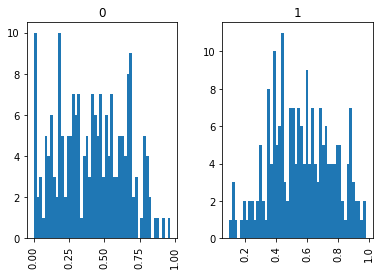

In [39]:
#rfm.predict_proba(Xtrain)
test_predix3 = rfm3.predict_proba(Xtest)[:,1]
test_predix3 = pd.DataFrame(test_predix3,Ytest,columns=['pred'])

plt.figure();
test_predix3.hist(by=test_predix3.index,bins=50)
plt.show()

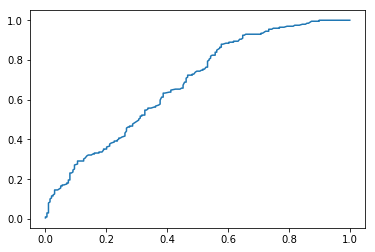

In [94]:
fpr, tpr, thresh = metrics.roc_curve(Ytest, test_predix3)

plt.figure();
plt.plot(fpr,tpr)
plt.show()

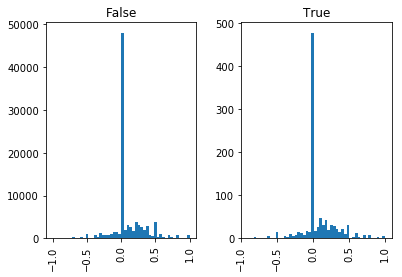

In [60]:
#
dfPol = pd.DataFrame(stSf.polarity.as_matrix(),stSf.slabel.as_matrix(),columns=['pol'])
#dfPol.head()

plt.figure();
dfPol.hist(by=dfPol.index,bins=50)
plt.show()

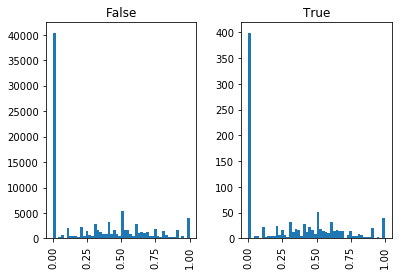

In [59]:
#
dfSub = pd.DataFrame(stSf.subjectivity.as_matrix(),stSf.slabel.as_matrix(),columns=['pol'])
#dfPol.head()

plt.figure();
dfSub.hist(by=dfSub.index,bins=50)
plt.show()

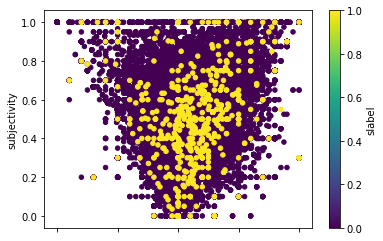

In [101]:
# polarity v. subjectivity

stSp = pd.concat([dfS_False,dfS_True],axis=0)

plt.figure();
stSp.plot.scatter(x='polarity',y='subjectivity',c='slabel',colormap='viridis')
plt.show()

In [ ]:
# does this change with stopwords included?
# gradient boosted trees?
# tuning parameters...

In [90]:

gbt = ensemble.GradientBoostingClassifier(learning_rate=0.3, n_estimators=200, max_depth=3)
gbt.fit(Xtrain,Ytrain)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.3, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [91]:
print(gbt.score(Xtrain,Ytrain))
print(gbt.score(Xtest,Ytest))

0.923899371069
0.628140703518


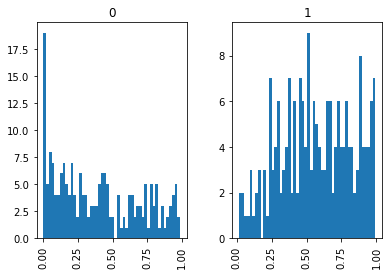

In [92]:
#rfm.predict_proba(Xtrain)
test_predix = gbt.predict_proba(Xtest)[:,1]
test_predix = pd.DataFrame(test_predix,Ytest,columns=['pred'])

plt.figure();
test_predix.hist(by=test_predix.index,bins=50)
plt.show()

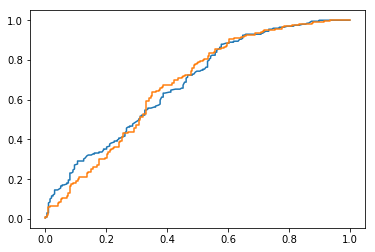

In [95]:
fpr1, tpr1, thresh = metrics.roc_curve(Ytest, test_predix)

plt.figure();
plt.plot(fpr,tpr,fpr1,tpr1)
plt.show()

In [102]:
dfS_True.head()

,slabel,alength,sposition,swcount,polarity,subjectivity
level_0,,,,,,
610,True,80,41,3,0.000000,0.000000
611,True,80,42,3,0.000000,0.000000
1040,True,153,123,9,0.214286,0.642857
1041,True,153,124,6,0.000000,0.000000
3213,True,50,27,6,0.700000,1.000000


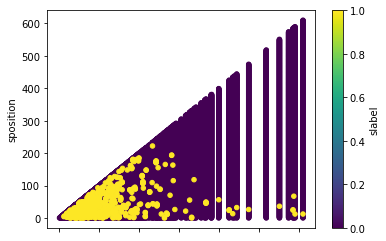

In [103]:
# look at basic features...

# article position
stSp = pd.concat([dfS_False,dfS_True],axis=0)

plt.figure();
stSp.plot.scatter(x='alength',y='sposition',c='slabel',colormap='viridis')
plt.show()

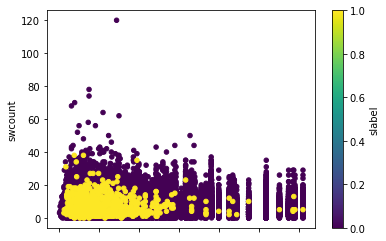

In [104]:
# look at basic features...

# word count
stSp = pd.concat([dfS_False,dfS_True],axis=0)

plt.figure();
stSp.plot.scatter(x='alength',y='swcount',c='slabel',colormap='viridis')
plt.show()

In [107]:
# more basic data exploration...

stS.columns

Index(['alength', 'index', 'postid', 'sentence', 'slabel', 'sposition',
       'swcount', 'stfidf', 'title', 'popdate', 'url', 'userid', 'username',
       'highlight', 'nlikes', 'ncomments', 'ntags', 'origdb', 'tags', 'text',
       'npar', 'polarity', 'subjectivity'],
      dtype='object')

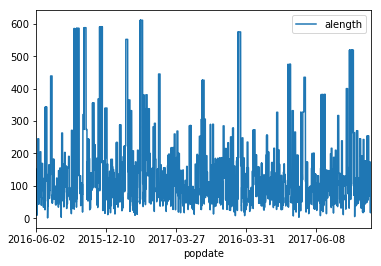

In [108]:
plt.figure();
stS.plot(x='popdate',y='alength',by='slabel')
plt.show()

In [114]:
def convert_K(nstr):
    spl = nstr.split('K')
    if len(spl)==1:
        return int(float(spl[0]))
    else:
        return int(float(spl[0])*1000)

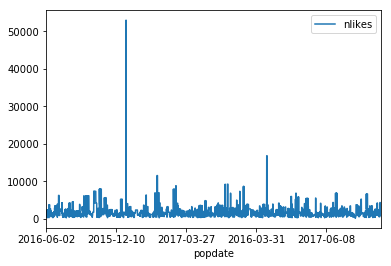

In [119]:
plt.figure();
#stS['nlikes'] = stS.nlikes.map(convert_K)
stS.plot(x='popdate',y='nlikes')
plt.show()

(95631, 23)


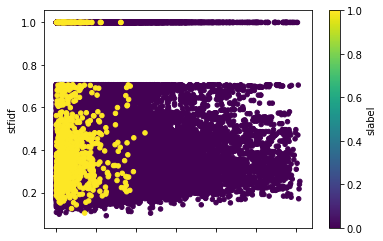

In [126]:
stSp = pd.concat([stS[stS.slabel==False],stS[stS.slabel==True]],axis=0)
print(stSp.shape)

plt.figure();
stSp.plot.scatter(x='sposition',y='stfidf',c='slabel',colormap='viridis')
plt.show()

In [129]:
stS.stfidf.shape
with open('maxtfidf.pkl','rb') as f:
    maxtfidf = pickle.load(f)

In [132]:
stS['maxtfidf'] = [m for m,bl in zip(maxtfidf,dfS_in_min_stA) if bl]

(95631, 24)


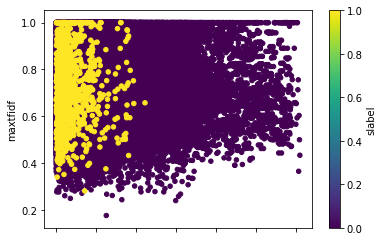

In [133]:
stSp = pd.concat([stS[stS.slabel==False],stS[stS.slabel==True]],axis=0)
print(stSp.shape)

plt.figure();
stSp.plot.scatter(x='sposition',y='maxtfidf',c='slabel',colormap='viridis')
plt.show()

(95631, 24)


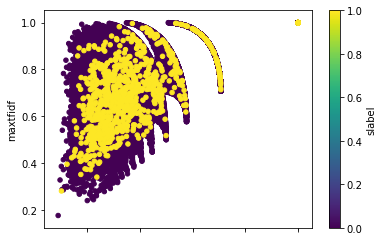

In [134]:
stSp = pd.concat([stS[stS.slabel==False],stS[stS.slabel==True]],axis=0)
print(stSp.shape)

plt.figure();
stSp.plot.scatter(x='stfidf',y='maxtfidf',c='slabel',colormap='viridis')
plt.show()

<h3>Better polarity and subjectivity scores...</h3>

In [138]:
# try polarity and subjectivity on text data with stop words IN

betterText = NLP.NLProcessor(stA.text,swords = [])
betterText.process_text(init_split_on='database', to_stem=False, 
                   break_on='.', origdb=list(stA.origdb))
betterTextList = betterText.get_text()

In [140]:
betterBlobs = []
for ax,a in enumerate(betterTextList):
    if ax%100 == 0:
        print(ax)
    if len(a)!=stA.nsent.iloc[ax]:
        print('fail: ',ax)
        print(len(a))
        print(stA.nsent.iloc[ax])
    for s in a:
        betterBlobs.append(TextBlob(' '.join(s)))

0
100
200
300
400
500
600
700
800
900


In [141]:
bpolarity = []
bsubjectivity = []
for sx,s in enumerate(betterBlobs):
    if sx%5000 == 0:
        print(sx)
    stmt = s.sentiment
    bpolarity.append(stmt[0])
    bsubjectivity.append(stmt[1])

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000


In [142]:
stS['betterPol'] = bpolarity
stS['betterSubj'] = bsubjectivity

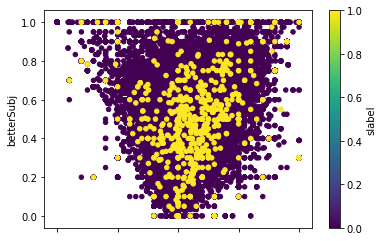

In [145]:
# polarity v. subjectivity

stSp = pd.concat([stS[stS.slabel==False],stS[stS.slabel==True]],axis=0)

plt.figure();
stSp.plot.scatter(x='betterPol',y='betterSubj',c='slabel',colormap='viridis')
plt.show()

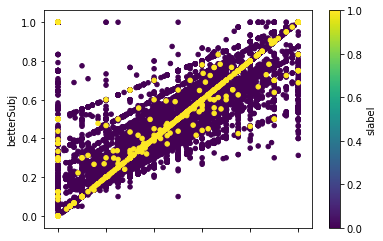

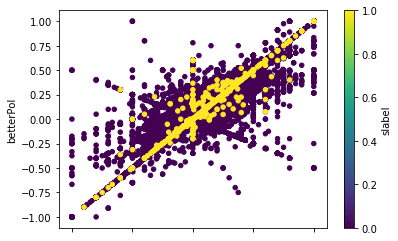

In [146]:
# polarity v. subjectivity

plt.figure();
stSp.plot.scatter(x='subjectivity',y='betterSubj',c='slabel',colormap='viridis')
plt.show()

plt.figure();
stSp.plot.scatter(x='polarity',y='betterPol',c='slabel',colormap='viridis')
plt.show()